In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load dataset
df = pd.read_csv('mlbb_heroes_aggregated.csv')

In [5]:
df['total_matches'] = df['total_picks'] + df['total_bans']
df['ban_rate'] = df['total_bans'] / df['total_matches'] * 100

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (130, 9)

First 5 rows:
     hero Primary_Role  total_picks  total_wins  total_losses  total_bans  \
0   aamon     Assassin           71          39            32          41   
1    akai         Tank         1581         799           782        1260   
2  aldous      Fighter          129          72            57         129   
3   alice         Mage         1069         541           528         677   
4   alpha      Fighter          525         253           272         300   

   overall_win_rate  total_matches   ban_rate  
0             54.93            112  36.607143  
1             50.54           2841  44.350581  
2             55.81            258  50.000000  
3             50.61           1746  38.774341  
4             48.19            825  36.363636  


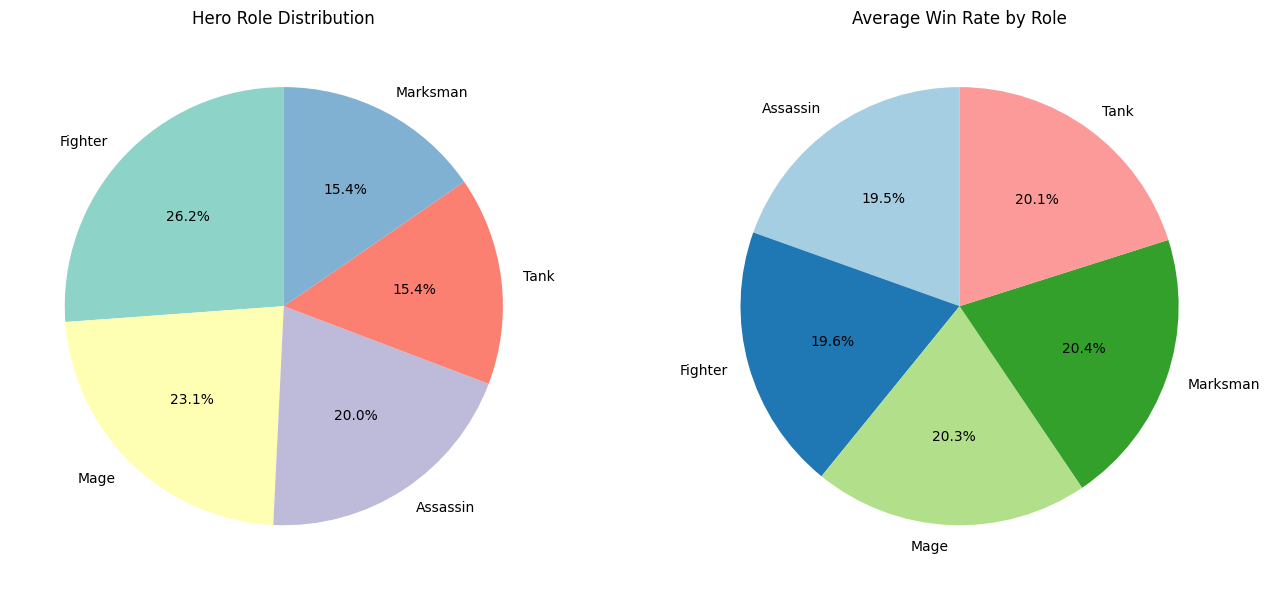

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart 1: Role Distribution
role_counts = df['Primary_Role'].value_counts()
axes[0].pie(role_counts.values, labels=role_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=plt.cm.Set3.colors)
axes[0].set_title('Hero Role Distribution')

# Pie Chart 2: Role-wise Average Win Rate
role_avg_winrate = df.groupby('Primary_Role')['overall_win_rate'].mean()
axes[1].pie(role_avg_winrate.values, labels=role_avg_winrate.index, autopct='%1.1f%%',
            startangle=90, colors=plt.cm.Paired.colors)
axes[1].set_title('Average Win Rate by Role')

plt.tight_layout()
plt.show()

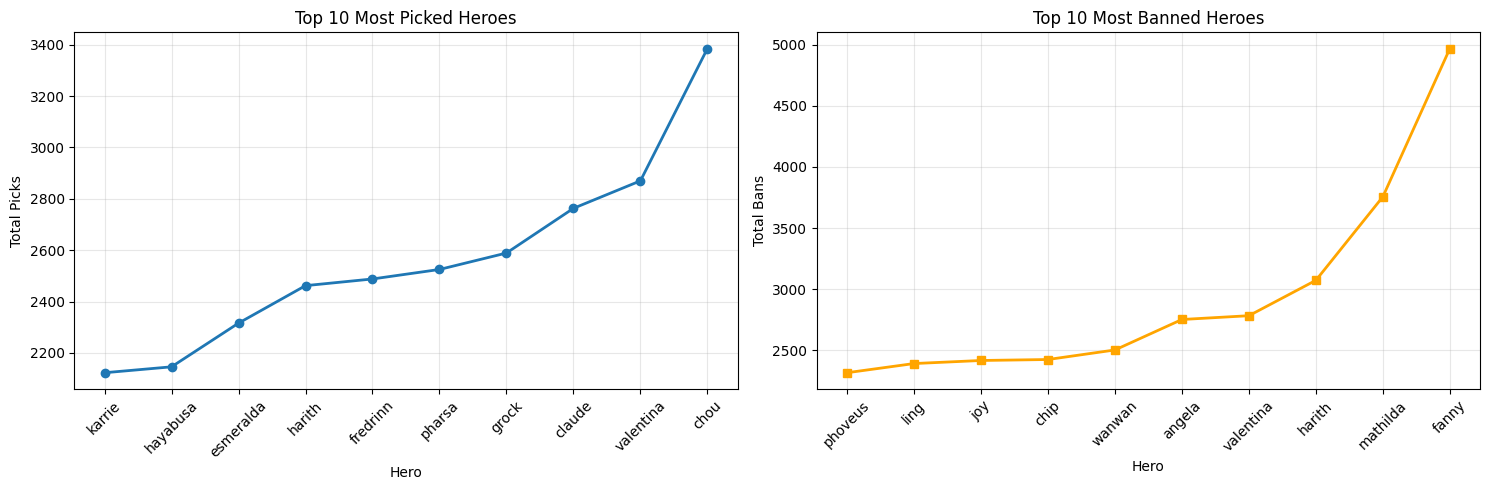

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Line Plot 1: Top 10 Most Picked Heroes
top_10_picks = df.nlargest(10, 'total_picks').sort_values('total_picks')
axes[0].plot(top_10_picks['hero'], top_10_picks['total_picks'], 
             marker='o', linewidth=2)
axes[0].set_title('Top 10 Most Picked Heroes')
axes[0].set_xlabel('Hero')
axes[0].set_ylabel('Total Picks')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Line Plot 2: Top 10 Most Banned Heroes
top_10_bans = df.nlargest(10, 'total_bans').sort_values('total_bans')
axes[1].plot(top_10_bans['hero'], top_10_bans['total_bans'], 
             marker='s', linewidth=2, color='orange')
axes[1].set_title('Top 10 Most Banned Heroes')
axes[1].set_xlabel('Hero')
axes[1].set_ylabel('Total Bans')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

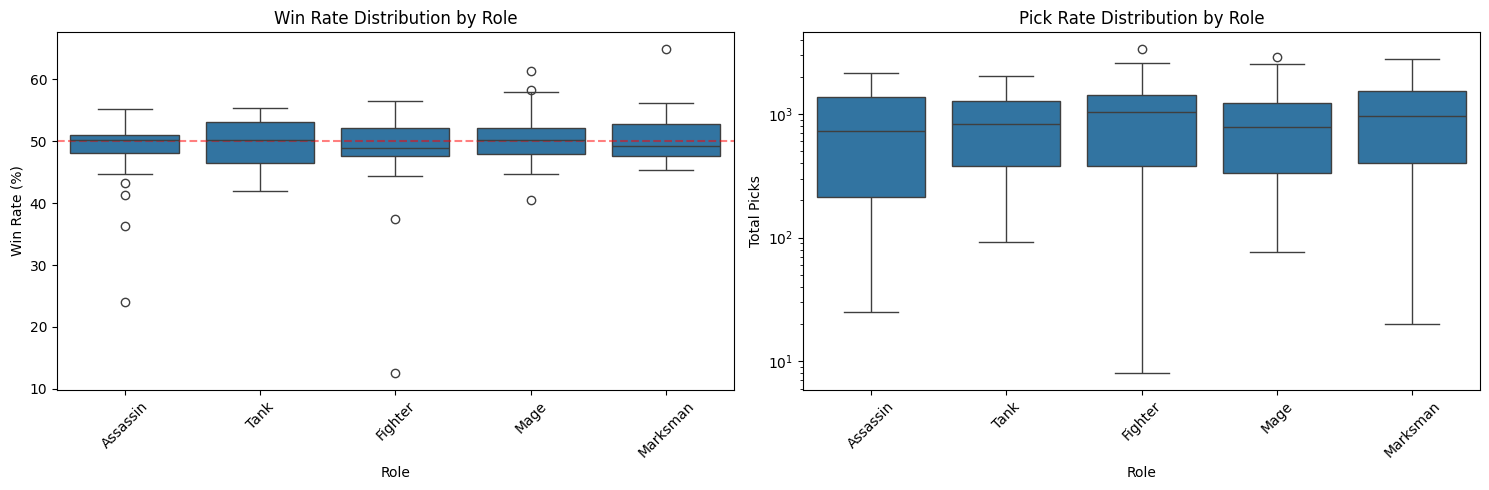

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box Plot 1: Win Rate Distribution by Role
sns.boxplot(data=df, x='Primary_Role', y='overall_win_rate', ax=axes[0])
axes[0].set_title('Win Rate Distribution by Role')
axes[0].set_xlabel('Role')
axes[0].set_ylabel('Win Rate (%)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=50, color='r', linestyle='--', alpha=0.5)

# Box Plot 2: Pick Rate Distribution by Role
sns.boxplot(data=df, x='Primary_Role', y='total_picks', ax=axes[1])
axes[1].set_title('Pick Rate Distribution by Role')
axes[1].set_xlabel('Role')
axes[1].set_ylabel('Total Picks')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

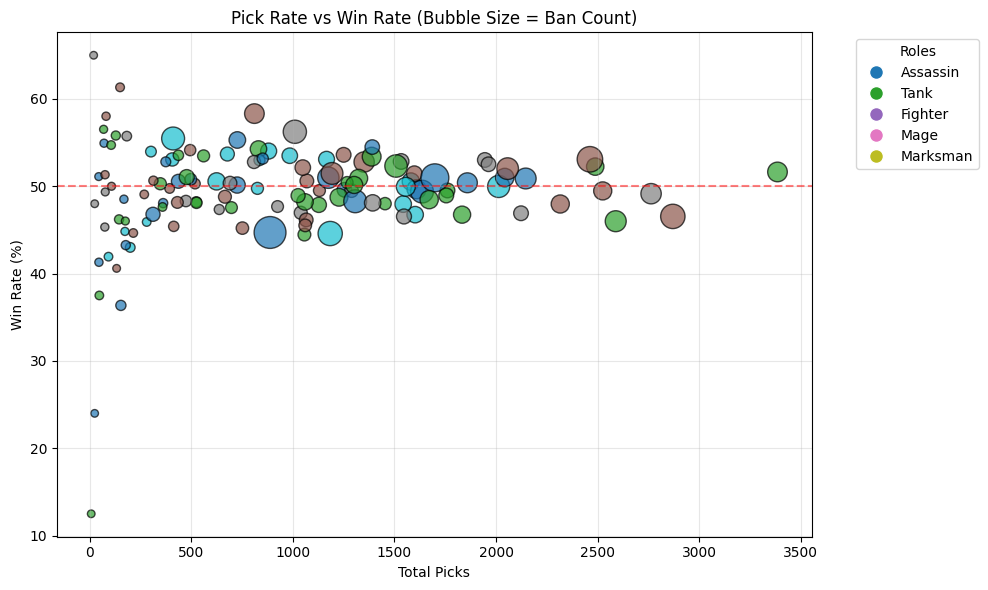

In [9]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(df['total_picks'], df['overall_win_rate'],
                     c=pd.Categorical(df['Primary_Role']).codes,
                     cmap='tab10',
                     s=df['total_bans']/10 + 30,
                     alpha=0.7,
                     edgecolors='black')

plt.title('Pick Rate vs Win Rate (Bubble Size = Ban Count)')
plt.xlabel('Total Picks')
plt.ylabel('Win Rate (%)')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Add legend for roles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=role,
                         markerfacecolor=plt.cm.tab10(i/len(df['Primary_Role'].unique())),
                         markersize=10) for i, role in enumerate(df['Primary_Role'].unique())]
plt.legend(handles=legend_elements, title='Roles', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

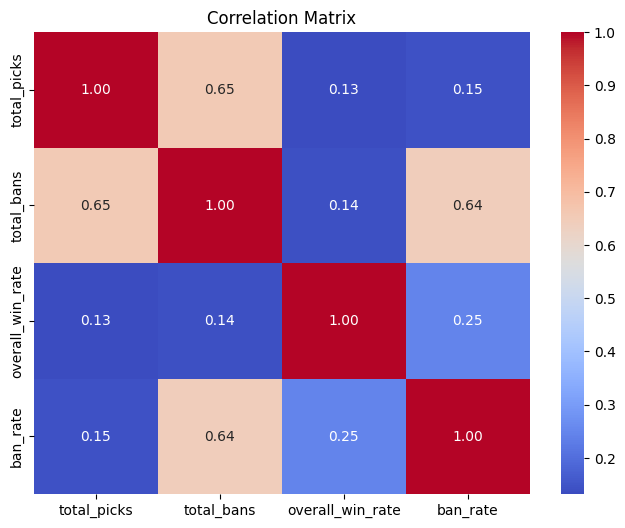

In [10]:
# Correlation Matrix
corr_matrix = df[['total_picks', 'total_bans', 'overall_win_rate', 'ban_rate']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
features = ['total_picks', 'total_bans', 'overall_win_rate', 'ban_rate']
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features for clustering: {features}")
print(f"Scaled data shape: {X_scaled.shape}")

Features for clustering: ['total_picks', 'total_bans', 'overall_win_rate', 'ban_rate']
Scaled data shape: (130, 4)


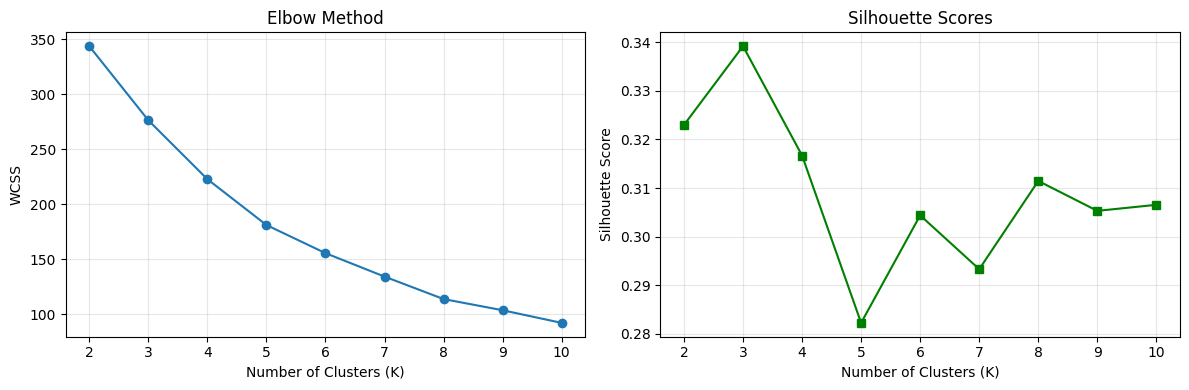

Optimal K based on silhouette score: 3


In [12]:
# Find optimal number of clusters
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_range, wcss, marker='o')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('WCSS')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='s', color='green')
axes[1].set_title('Silhouette Scores')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal K
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal K based on silhouette score: {optimal_k}")

In [13]:
# Apply K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)


df['cluster'] = clusters

print("Cluster Distribution:")
print(df['cluster'].value_counts().sort_index())

Cluster Distribution:
cluster
0    71
1    57
2     2
Name: count, dtype: int64


In [14]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

print("PCA Explained Variance Ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum():.3f}")

PCA Explained Variance Ratio:
PC1: 0.518
PC2: 0.245
Total Explained Variance: 0.763


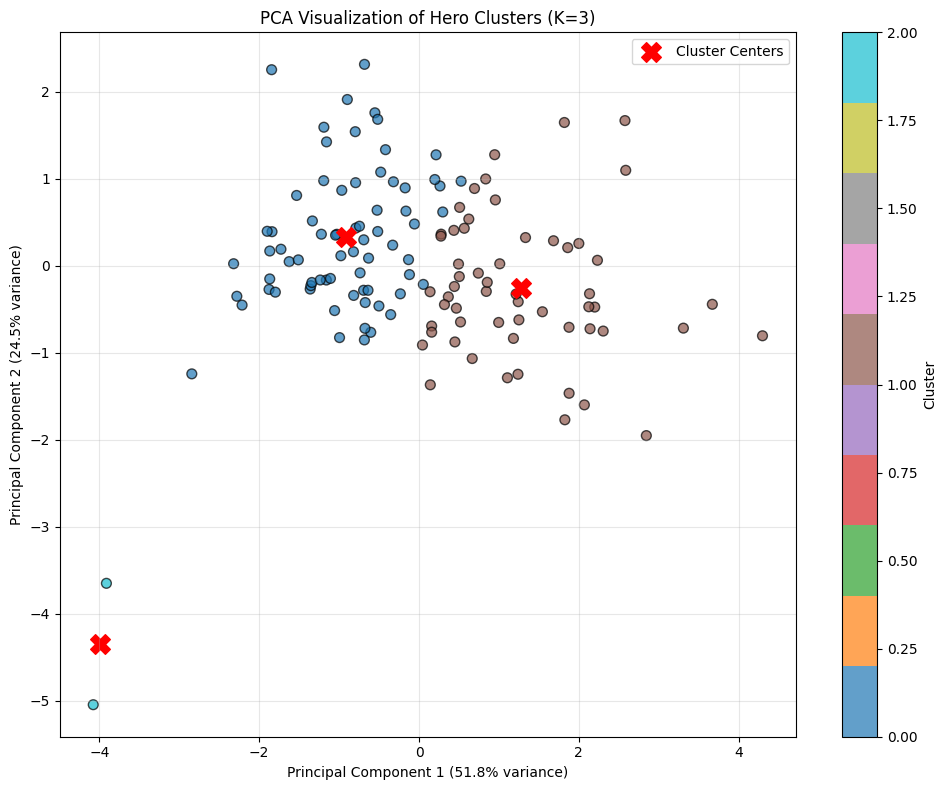

In [15]:
plt.figure(figsize=(10, 8))

# Scatter plot with clusters
scatter = plt.scatter(df['pca1'], df['pca2'], 
                     c=df['cluster'], 
                     cmap='tab10',
                     s=50, 
                     alpha=0.7,
                     edgecolors='black')

plt.title(f'PCA Visualization of Hero Clusters (K={optimal_k})')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)


centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', s=200, marker='X', label='Cluster Centers')

plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [16]:
print("Cluster Analysis:")


for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    
    avg_picks = cluster_data['total_picks'].mean()
    avg_bans = cluster_data['total_bans'].mean()
    avg_winrate = cluster_data['overall_win_rate'].mean()
    avg_banrate = cluster_data['ban_rate'].mean()
    
    # Determine cluster category based on thresholds
    if avg_picks > 1000 and avg_winrate > 52:
        category = "META"
    elif avg_bans > 500 and avg_banrate > 40:
        category = "PRIORITY BAN"
    elif avg_picks > 500 and avg_winrate < 48:
        category = "POPULAR BUT WEAK"
    elif avg_winrate > 54:
        category = "HIGH WIN RATE"
    else:
        category = "SITUATIONAL"
    
    print(f"\nCluster {cluster_id} - {category}:")
    print(f"  Heroes: {len(cluster_data)}")
    print(f"  Avg Picks: {avg_picks:.0f}")
    print(f"  Avg Bans: {avg_bans:.0f}")
    print(f"  Avg Win Rate: {avg_winrate:.2f}%")
    print(f"  Avg Ban Rate: {avg_banrate:.2f}%")
    
# Overall evaluation
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"\nClustering Evaluation:")
print(f"  Silhouette Score: {silhouette_avg:.3f}")
print(f"  Number of clusters: {optimal_k}")
print(f"  Total heroes clustered: {len(df)}")

Cluster Analysis:

Cluster 0 - SITUATIONAL:
  Heroes: 71
  Avg Picks: 473
  Avg Bans: 306
  Avg Win Rate: 49.30%
  Avg Ban Rate: 37.59%

Cluster 1 - PRIORITY BAN:
  Heroes: 57
  Avg Picks: 1575
  Avg Bans: 1601
  Avg Win Rate: 50.64%
  Avg Ban Rate: 49.60%

Cluster 2 - SITUATIONAL:
  Heroes: 2
  Avg Picks: 16
  Avg Bans: 0
  Avg Win Rate: 18.25%
  Avg Ban Rate: 5.56%

Clustering Evaluation:
  Silhouette Score: 0.339
  Number of clusters: 3
  Total heroes clustered: 130
